In [1]:
# %matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

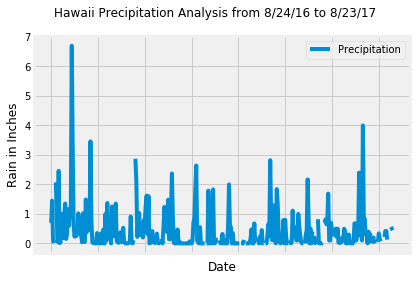

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# Perform a query to retrieve the data and precipitation scores

prcp_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    group_by(Measurement.date).all()
    
#prcp_data
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
# Sort the dataframe by date

prcp_data_df.set_index('date')
type(prcp_data_df)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot('date','prcp', use_index = True)
# Rotate the xticks for the dates
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.suptitle("Hawaii Precipitation Analysis from 8/24/16 to 8/23/17")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
# plt.tight_layout()
plt.savefig("Hawaii_Precipitation_Analysis")
plt.show()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [28]:
# How many stations are available in this dataset?
stations_count = session.query(Station.station).count()
print("There are {} stations.".format(stations_count))

There are 9 stations.


In [29]:
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.tobs))\
                .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
    
active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# What are the most active stations? #base on the most active station 
most_active = active_stations[0][0]
print("The most active station was the", most_active,"with", active_stations[0][1],"records")

The most active station was the USC00519281 with 2772 records


In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
l_temp = session.query(Measurement.station,Measurement.date, Measurement.tobs)\
                        .filter(Measurement.station == most_active).\
                           filter(Measurement.date >= "2016-08-23").order_by(Measurement.tobs.asc()).first()

# print(l_temp)

# highest temperature recorded ?
M_temp = session.query(Measurement.station,Measurement.date, Measurement.tobs,).filter(Measurement.station == most_active)\
                            .filter(Measurement.date >= "2016-08-23").order_by((Measurement.tobs.desc())).first()
print(M_temp)

('USC00519281', '2017-08-06', 83.0)


In [32]:
#average temperature ?
avg_temp = session.query(Measurement.station,Measurement.date, func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active).filter(Measurement.date >= "2016-08-23").all()
                    
avg_temp

[('USC00519281', '2017-08-18', 73.10795454545455)]

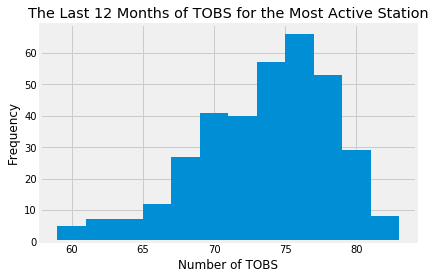

In [33]:
# Choose the station with the highest number of temperature observations.

h_obser = session.query(Measurement.station,Measurement.tobs,func.count(Measurement.tobs)).\
                group_by(Measurement.tobs, Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_data = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active).filter(Measurement.date >= "2016-08-23").all()

#converting the data to a list 
tobs_data = []
for row in most_active_data:
    tobs_data.append(row[0])
    
# type(tobs_data)
# Plotting the results as a Histogram   
plt.hist(tobs_data, bins = 12 )
plt.title("The Last 12 Months of TOBS for the Most Active Station")
plt.xlabel("Number of TOBS")
plt.ylabel("Frequency")
plt.savefig("Most_Active_station")
plt.show()

In [34]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string he format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
start_date = "2014-12-20"
end_date= "2015-01-05"

# for your trip using the previous year's data for those same dates.
Tmin, Tavg, Tmax = calc_temps(start_date, end_date )[0]

# Test 

type(Tmax)

float

<function matplotlib.pyplot.show>

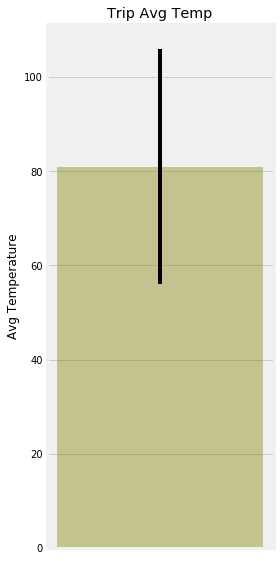

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plt.title("Trip Avg Temp")

fig, ax = plt.subplots(figsize = plt.figaspect(2))
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Avg Temperature")
xpos = 1 
yerr= Tmax-Tmin
ax.bar(xpos,Tmax, yerr= yerr, alpha = 0.4, color = 'olive')
fig.tight_layout()
ax.set_xticks([])
plt.savefig("Trip_Temp_Avg")
plt.show 

In [37]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


station_rain = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation)\
                    .filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).group_by(Station.name).order_by(func.sum(Measurement.prcp)).all()

print(station_rain)

[('USC00516128', 25.310000000000002, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), ('USC00516128', 25.310000000000002, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00516128', 25.310000000000002, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00516128', 25.310000000000002, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00516128', 25.310000000000002, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00516128', 25.310000000000002, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), ('USC00516128', 25.310000000000002, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00516128', 25.310000000000002, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00516128', 25.310000000000002, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]
